## Cricket Data EDA and ML models Evaluation 
### Notebook Summary
#### Data Cleaning & Preparation

- Performed EDA to understand dataset shape, types, and issues.

- Dropped null rows inspected them and confirmed they were garbage entries, so removal was the best choice.

- Dropped logically invalid rows (e.g., negative balls, wickets > 10). 
I might fill values forward/backward depending on the scenario, but here they were clearly garbage as well .

- After cleaning all columns had correct dtypes (int for most, float with 2 decimals for run rate).

#### Exploratory Visualizations

- Created fundamental but useful plots to understand data distribution and match dynamics

#### Baseline ML Model

- Started with **Logistic Regression**, since the dataset has only 4 raw features and LR provides a simple, interpretable baseline, achived >75% accuracy which is reasonable for a base model.

**Implemented Random Forest Classifier.**

- Performance improved significantly, achieving >95% accuracy.

- It captures nonlinear interactions.

- Using heavier ensembles (like boosting) might risk overfitting as we have very few features.

### Feature Engineering

**Added cricket-specific features:**

1. Runs Needed (target - total_runs)

2. Required Run Rate (RRR) = runs per over needed to win

3. Wickets Ratio = NUmber of wickets in hand

**While these engineered features didn’t drastically improve accuracy, they:**

- Provide more cricket insights.

- Allow for better interpretability (align with real-world match commentary and strategy).

- Could support richer visualizations for decision-making.


### Curiosity

During my analysis, I noticed something interesting that I wanted to clarify.
Since every match starts from the same initial state (e.g., 0 wickets, 120 balls left, and a given target), it means multiple rows in the dataset begin from identical conditions as well like we have multiple matches in reality where targets are same.
However, despite having the same starting state, the final outcomes across matches can be different (some wins, some losses).
My curiosity is: does having such repeated starting states with different outcomes create ambiguity in the dataset, or is it actually beneficial


### 1.1 EDA, Data Cleaning and Visualization


#### Importing Libraries

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score ,classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

#### Definig Paths

In [130]:
DATA_PATH = "data/cricket_dataset.csv"
CLEANED_PATH = "data/cricket_dataset_clean.csv"

#### Get to know more about the data

In [131]:
df = pd.read_csv(DATA_PATH)

In [132]:
df.shape

(15691, 5)

In [133]:
df.head()

,total_runs,wickets,target,balls_left,won
0,0.0,0.0,125,119.0,1
1,0.0,0.0,125,118.0,1
2,1.0,0.0,125,117.0,1
3,1.0,1.0,125,116.0,1
4,1.0,1.0,125,115.0,1


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15691 entries, 0 to 15690
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_runs  15689 non-null  float64
 1   wickets     15689 non-null  float64
 2   target      15691 non-null  int64  
 3   balls_left  15689 non-null  float64
 4   won         15691 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 613.1 KB


In [135]:
df.describe()

,total_runs,wickets,target,balls_left,won
count,15689.000000,15689.000000,15691.000000,15689.000000,15691.000000
mean,71.395691,2.538530,156.716462,63.766652,0.621184
std,45.430853,2.153691,28.713984,33.006166,0.485108
min,0.000000,0.000000,59.000000,-3.000000,0.000000
25%,34.000000,1.000000,136.000000,36.000000,0.000000
50%,68.000000,2.000000,156.000000,65.000000,1.000000
75%,105.000000,4.000000,180.000000,92.000000,1.000000
max,203.000000,10.000000,238.000000,119.000000,1.000000


In [136]:
df.isnull().sum()

total_runs    2
wickets       2
target        0
balls_left    2
won           0
dtype: int64

In [137]:
missing_rows = df[df.isnull().any(axis=1)]
print("Rows with Missing Values:")
print(missing_rows)

Rows with Missing Values:
       total_runs  wickets  target  balls_left  won
3336          NaN      NaN     117         NaN    0
14233         NaN      NaN     102         NaN    0


#### Droping null rows as I inspect those rtows are just guarbage values also conver dtypes of all co,umns into int as there is no need to keep values in float

In [138]:
df1 = df.dropna()
df1 = df1.astype(int)


In [139]:
df1.isna().sum()

total_runs    0
wickets       0
target        0
balls_left    0
won           0
dtype: int64

In [140]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15689 entries, 0 to 15690
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   total_runs  15689 non-null  int64
 1   wickets     15689 non-null  int64
 2   target      15689 non-null  int64
 3   balls_left  15689 non-null  int64
 4   won         15689 non-null  int64
dtypes: int64(5)
memory usage: 735.4 KB


### Key Insights
- Checking is logically any wrong value in the data 

In [141]:
invalid_wickets = df1[(df1["wickets"] > 10) | (df1["wickets"] < 0)]
if not invalid_wickets.empty:
    print("Wickets > 10 detected:")
    print(invalid_wickets)

In [142]:
invalid_balls = df1[(df1["balls_left"] > 120) | (df1["balls_left"] <0)] 
if not invalid_balls.empty:
    print("Balls_left outside 0-120 detected:")
    print(invalid_balls)

Balls_left outside 0-120 detected:
       total_runs  wickets  target  balls_left  won
454           130        9     132          -1    0
4932          156        7     181          -1    0
4933          157        7     181          -2    0
5385          142        9     176          -1    0
6386          164        8     183          -1    0
7342          163        8     163          -1    0
14878         150        7     154          -1    0
14879         151        7     154          -2    0
14880         151        8     154          -3    0


In [143]:
invalid_runs = df1[df1["total_runs"] < 0]
if not invalid_runs.empty:
    print("Negative total_runs detected:")
    print(invalid_runs)

In [144]:
df1.shape

(15689, 5)

In [145]:
df1 = df1[~df1.index.isin(invalid_balls.index)]
print(f"Dropped {len(invalid_balls)} invalid rows. New shape: {df1.shape}")


Dropped 9 invalid rows. New shape: (15680, 5)


#### Saving clean data

In [146]:
df1.to_csv(CLEANED_PATH, index=False)

In [147]:
df = pd.read_csv(CLEANED_PATH)

### Visualiztion

#### 1. Target Distribution (Win vs Loss)
- How balanced the dataset is between wins and losses.
- If one class dominates, it highlights a class imbalance problem for the model.


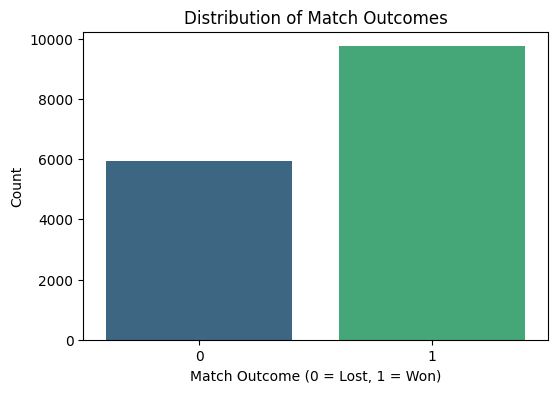

In [148]:
plt.figure(figsize=(6,4))
sns.countplot(x="won", data=df, palette="viridis")
plt.title("Distribution of Match Outcomes")
plt.xlabel("Match Outcome (0 = Lost, 1 = Won)")
plt.ylabel("Count")
plt.show()


### 2. Boxplot: Total Runs vs Outcome
- Distribution of total runs scored in winning vs losing games.


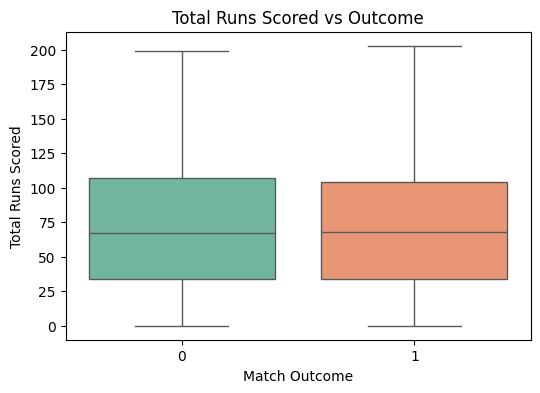

In [149]:
plt.figure(figsize=(6,4))
sns.boxplot(x="won", y="total_runs", data=df1, palette="Set2")
plt.title("Total Runs Scored vs Outcome")
plt.xlabel("Match Outcome")
plt.ylabel("Total Runs Scored")
plt.show()


### 3. Scatter: Runs Needed vs Balls Left (Colored by Outcome)
- The “pressure zone” of a chase.
- Winning teams cluster where fewer runs are needed with more balls left.
- Losing teams dominate when runs required are high and balls left are low.




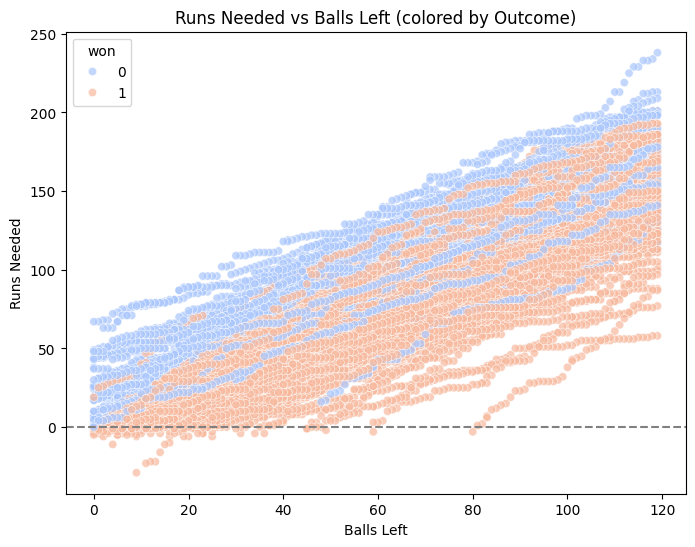

In [150]:
df["runs_needed"] = df["target"] - df["total_runs"]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="balls_left", y="runs_needed",
    hue="won", data=df, palette="coolwarm", alpha=0.7
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Runs Needed vs Balls Left (colored by Outcome)")
plt.xlabel("Balls Left")
plt.ylabel("Runs Needed")
plt.show()


### 4. Wickets vs Outcome (Barplot/Countplot)
- How the number of wickets lost influences winning chances.
- Observation teams losing wickets > 6 have very low wining probability

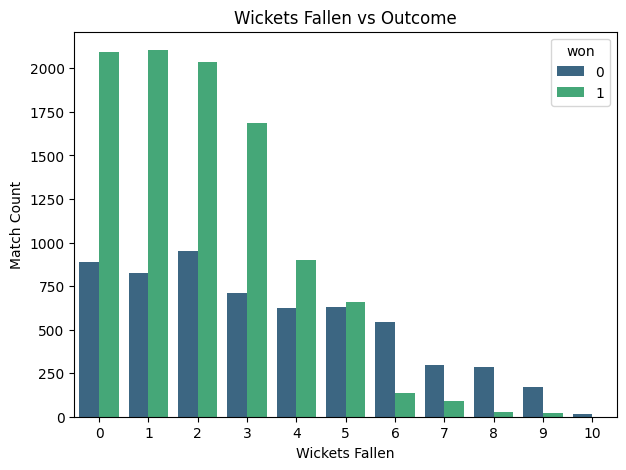

In [151]:
plt.figure(figsize=(7,5))
sns.countplot(x="wickets", hue="won", data=df,palette="viridis")
plt.title("Wickets Fallen vs Outcome")
plt.xlabel("Wickets Fallen")
plt.ylabel("Match Count")
plt.show()


### 5. Correlation Heatmap
- Helps identify which features are more predictive(high corealtion with target variable)

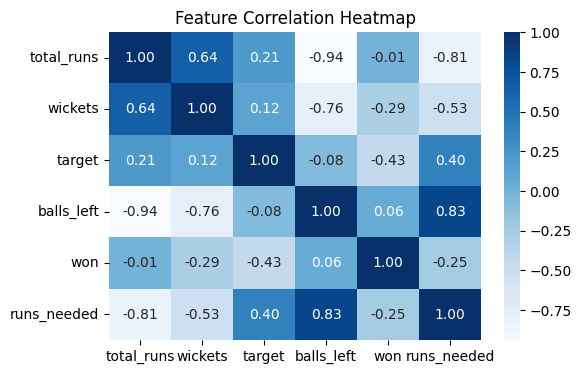

In [152]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


### 1.2 ML Models Creation & Evaluation

In [153]:
df = pd.read_csv(CLEANED_PATH)

Train Test Split

In [154]:
X = df.drop("won", axis=1)
y = df["won"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (12544, 4) Test shape: (3136, 4)


In [155]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Logistic Regression

In [156]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_s, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [157]:
y_pred = lr.predict(X_test_s)

In [158]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7809311224489796

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.66      0.70      1187
           1       0.81      0.85      0.83      1949

    accuracy                           0.78      3136
   macro avg       0.77      0.76      0.76      3136
weighted avg       0.78      0.78      0.78      3136


Confusion Matrix:
 [[ 788  399]
 [ 288 1661]]


Random Forest

In [159]:
rf = RandomForestClassifier(
    n_estimators=50,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [160]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9655612244897959

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1187
           1       0.97      0.98      0.97      1949

    accuracy                           0.97      3136
   macro avg       0.96      0.96      0.96      3136
weighted avg       0.97      0.97      0.97      3136


Confusion Matrix:
 [[1126   61]
 [  47 1902]]


### 1.3 Feature Engineering 

1. Runs Needed 

- Captures the exact challenge left.

- The lower this number, the higher the chance of winning.

2. Required Run Rate (RRR)

- Runs per over required to win.

- Commentators always talk about RRR as a key metric.

- High RRR usually signals low win probability.

3. Wickets Ratio

- Represents wickets in hands.

- Teams with many wickets in hand are more likely to accelerate in the final overs.

In [161]:
# Ensure runs_needed is never negative
df["runs_needed"] = (df["target"] - df["total_runs"]).clip(lower=0).astype(int)

df["required_run_rate"] = np.where(
    df["balls_left"] > 0,
    (df["runs_needed"] / (df["balls_left"] / 6)).round(2),
    0.00
)

df["required_run_rate"] = np.where(df["runs_needed"] == 0, 0.00, df["required_run_rate"])




In [162]:

df["wickets_ratio"] = (((10 - df["wickets"]) / 10) * 10).astype(int)

In [163]:
print(df.dtypes)
df.head()
df.to_csv(CLEANED_PATH, index=False)

total_runs             int64
wickets                int64
target                 int64
balls_left             int64
won                    int64
runs_needed            int64
required_run_rate    float64
wickets_ratio          int64
dtype: object


In [164]:
X = df.drop("won", axis=1)
y = df["won"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [165]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [166]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [167]:

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_s, y_train)

y_pred_lr = lr.predict(X_test_s)


In [168]:

print("Logistic Regression (with engineered features)")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Logistic Regression (with engineered features)
Accuracy: 0.7793367346938775

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.66      0.69      1187
           1       0.80      0.85      0.83      1949

    accuracy                           0.78      3136
   macro avg       0.77      0.76      0.76      3136
weighted avg       0.78      0.78      0.78      3136

Confusion Matrix:
 [[ 780  407]
 [ 285 1664]]


In [169]:
rf = RandomForestClassifier(
    n_estimators=50,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [170]:
print("Random Forest (with engineered features)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Random Forest (with engineered features)
Accuracy: 0.9693877551020408

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1187
           1       0.97      0.98      0.98      1949

    accuracy                           0.97      3136
   macro avg       0.97      0.97      0.97      3136
weighted avg       0.97      0.97      0.97      3136


Confusion Matrix:
 [[1132   55]
 [  41 1908]]
